In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, average, minimum, maximum, add
from keras.models import Model
from keras.optimizers import Adagrad
from keras.constraints import min_max_norm

from sklearn import preprocessing

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval, samEval_bestpp, samEval_reyes

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/05_combination_samEval2018/'

In [4]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval_reyes()

In [5]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

#### POS Features

In [7]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

train_pos =get_pos('output_trainTestData/SamReyes_all_train_pos.csv')
test_pos = get_pos('output_trainTestData/SamReyes_all_test_pos.csv')

#### Sentiment Features

In [8]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/SamReyes_all_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamReyes_all_test_data_sentiment_blob.csv')

# Train the model

In [12]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

# Combine Stopp NaN and additional Data

In [10]:
#First part
wv_layer_combinestoppaddatta = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_combinestoppaddatta = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_combinestoppaddatta = wv_layer_combinestoppaddatta(comment_input_combinestoppaddatta)
x_first_combinestoppaddatta = Dense(600, activation='relu')(embedded_sequences_combinestoppaddatta)
x_first_combinestoppaddatta = Flatten()(x_first_combinestoppaddatta)

#Second part
senti_input_combinestoppaddatta_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second_combinestoppaddatta = Dense(600, activation='relu')(senti_input_combinestoppaddatta_blob)

#Thrid part
senti_input_combinestoppaddatta_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third_combinestoppaddatta = Dense(600, activation='relu')(senti_input_combinestoppaddatta_pos)

#Concatination
concat_combinestoppaddatta = concatenate([x_first_combinestoppaddatta, x_second_combinestoppaddatta, x_third_combinestoppaddatta])

preds_combinestoppaddatta = Dense(2, activation='softmax')(concat_combinestoppaddatta)

model_combinestoppaddatta = Model(inputs=[comment_input_combinestoppaddatta, senti_input_combinestoppaddatta_blob, senti_input_combinestoppaddatta_pos], outputs=preds_combinestoppaddatta)
model_combinestoppaddatta.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 99)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 99, 300)      10195800    input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 99, 600)      180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 99)           0                                            
_____________________________________

Instructions for updating:
Use tf.cast instead.


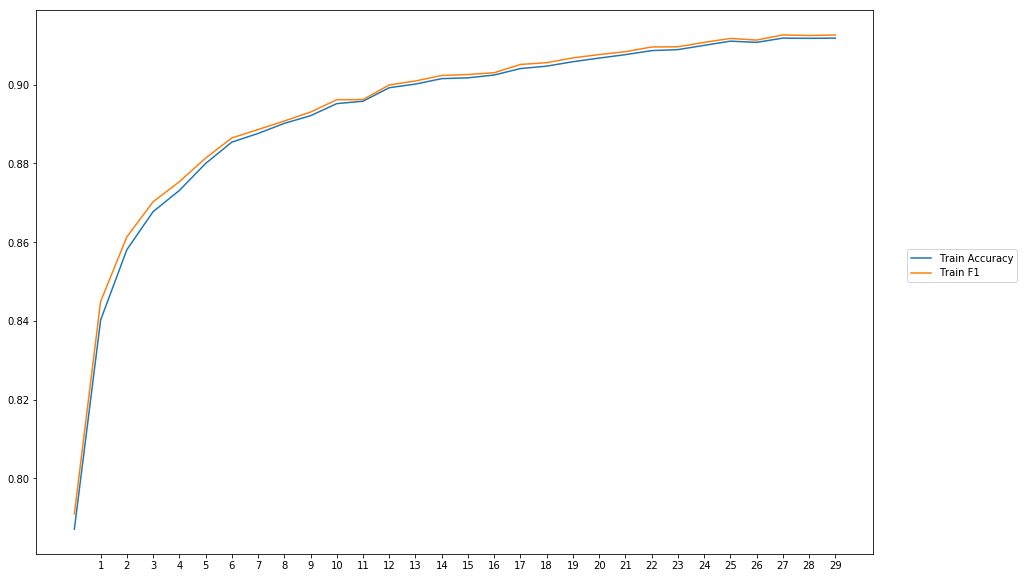


-----Test Scores----
Loss: 0.26410797356448407
Accuracy: 86.93426173289438
Precision: 85.6543624125145
Recall: 87.33960649754749
F1: 86.48877093920886


In [13]:
train_evaluate_three_inputs_with_terminate(model_combinestoppaddatta, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'CombineStoppAddData')